In [52]:
# Librerie da scaricare
import os
import logging
import warnings
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from utils.constant import *
from datetime import datetime

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Settaggio
def setup_logging(log_file):
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)

    if logger.hasHandlers():
        logger.handlers.clear()

    file_handler = logging.FileHandler(log_file, mode='w')
    
    formatter = logging.Formatter('%(message)s')
    file_handler.setFormatter(formatter)

    logger.addHandler(file_handler)

    return logger

def close_logger(logger):
    handlers = logger.handlers[:]
    for handler in handlers:
        handler.close()
        logger.removeHandler(handler)

# Economici
Aggiungere i dati del Real GDP al dataset italiano per valutarne la crescita nazionale e il PIL pro Capite per una visione dell'economia della popolazione

## Dataset

In [16]:
# Carica datasets

plt.style.use('dark_background')

dataset_real_gdp = pd.read_csv(RAW_DATA_ECONOMICS + 'real_gdp.csv')
dataset_ppc = pd.read_csv(RAW_DATA_ECONOMICS + 'pil_pro_capite.csv')

### Real GDP


#### Cleaning Dataset

In [17]:
# Clean dataset

columns = {
    'DATE': 'Anno',
    'RGDPNAITA666NRUG': "real_GDP"
}

def convert_date_to_year(date):
    return int(date[:4])

def convert_to_discrate_value(value):
    return int(value)

dataset_real_gdp = dataset_real_gdp.rename(columns=columns)
dataset_real_gdp['Anno'] = dataset_real_gdp['Anno'].apply(convert_date_to_year)
dataset_real_gdp['real_GDP'] = dataset_real_gdp['real_GDP'].apply(convert_to_discrate_value)


In [18]:
# [C] Real GDP Italian

plt.figure(figsize=(10, 10))

plt.plot(dataset_real_gdp['Anno'], dataset_real_gdp['real_GDP'], label='Real GDP')

plt.xticks(rotation=45)
plt.legend()
plt.grid(True, color='gray', alpha=0.3)

os.makedirs(ECONOMICS_ORIGINAL_CHART_PATH, exist_ok=True)

plt.savefig(ECONOMICS_ORIGINAL_CHART_PATH + 'real_gdp.png')
plt.close()

#### Data Imputation
Prevediamo i dati del 2020, 2021, 2022 e 2023

In [19]:
gdp_series = dataset_real_gdp['real_GDP']

In [20]:
# Grid search per trovare il miglior modello ARIMA

warnings.filterwarnings("ignore")

p = range(0, 5)
d = range(0, 2)  
q = range(0, 5)

pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_pdq = None
best_model = None

for param in pdq:
    try:
        model = ARIMA(gdp_series, order=param)
        model_fit = model.fit()
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_pdq = param
            best_model = model_fit
    except:
        continue

In [21]:
# [M] Modello per la predizione dei dati futuri

model = ARIMA(gdp_series, order=best_pdq)
model_fit = model.fit()

forecast = model_fit.forecast(steps=4)
forecast_index = [2020, 2021, 2022, 2023]
forecast_df = pd.DataFrame({
    "Anno": forecast_index,
    "Forecast": forecast.astype(int)
})

plt.figure(figsize=(10, 10))
plt.plot(dataset_real_gdp['Anno'], dataset_real_gdp['real_GDP'], label='Real GDP')
plt.plot(forecast_df['Anno'], forecast_df['Forecast'], label='Forecast')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, color='gray', alpha=0.3)

os.makedirs(ECONOMICS_PREDICTION_CHART_PATH, exist_ok=True)

plt.savefig(ECONOMICS_PREDICTION_CHART_PATH + 'real_gdp_with_prediction.png')
plt.close()

In [22]:
# Salva il dataset completo

forecast_df.rename(columns={'Forecast': 'real_GDP'}, inplace=True)

dataset_real_gdp = pd.concat([dataset_real_gdp, forecast_df], ignore_index=True)

os.makedirs(CLEANED_DATA_ECONOMICS, exist_ok=True)

dataset_real_gdp.to_csv(CLEANED_DATA_ECONOMICS + 'real_gdp.csv', index=False)
dataset_real_gdp.to_parquet(CLEANED_DATA_ECONOMICS + 'real_gdp.parquet', index=False)

### PIL Pro Capite

#### Data Cleaning

In [23]:
# Data Cleaning

columns = {
    'DATE': 'Anno',
    'NYGDPPCAPKDITA': "pil_pro_capite"
}

def convert_date_to_year(date):
    return int(date[:4])

def convert_to_discrate_value(value):
    return int(value)

dataset_ppc = dataset_ppc.rename(columns=columns)
dataset_ppc['Anno'] = dataset_ppc['Anno'].apply(convert_date_to_year)
dataset_ppc['pil_pro_capite'] = dataset_ppc['pil_pro_capite'].apply(convert_to_discrate_value)

In [24]:
# [C] PIL pro capite Italian

plt.figure(figsize=(10, 10))

plt.plot(dataset_ppc['Anno'], dataset_ppc['pil_pro_capite'], label='PIL pro capite', color="#6B30C2")

plt.xticks(rotation=45)

plt.legend()
plt.grid(True, color='gray', alpha=0.3)

os.makedirs(ECONOMICS_ORIGINAL_CHART_PATH, exist_ok=True)

plt.savefig(ECONOMICS_ORIGINAL_CHART_PATH + 'pil_pro_capite.png')
plt.close()

#### Data Imputetion

In [25]:
# Grid search per trovare il miglior modello ARIMA
from statsmodels.tsa.stattools import adfuller

ppc_series_reversed = dataset_ppc['pil_pro_capite'][::-1]

p = range(0, 5)
d = range(0, 2)  
q = range(0, 5)

def check_stationarity(series):
    result = adfuller(series)
    return result[1] < 0.05

ppc_series_processed = ppc_series_reversed
if not check_stationarity(ppc_series_reversed):
    ppc_series_processed = ppc_series_reversed.diff().dropna()

p = range(0, 5)
d = range(0, 2)
q = range(0, 5)
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_pdq = None
best_model = None

for param in pdq:
    try:
        model = ARIMA(ppc_series_processed, order=param)
        model_fit = model.fit(start_params=[0.01] * sum(param))
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_pdq = param
            best_model = model_fit
    except:
        continue

In [26]:
# [M] Modello per la predizione dei dati passati

model = ARIMA(ppc_series_reversed, order=best_pdq)
model_fit = model.fit()

forecast = model_fit.forecast(steps=10)
forecast_index = [1959, 1958, 1957, 1956, 1955, 1954, 1953, 1952, 1951, 1950]
forecast_df = pd.DataFrame({
    "Anno": forecast_index,
    "Forecast": forecast.astype(int)
})  

forecast_df = forecast_df.iloc[::-1].reset_index(drop=True)

plt.figure(figsize=(10, 10))
plt.plot(dataset_ppc['Anno'], dataset_ppc['pil_pro_capite'], label='PIL pro capite', color="#6B30C2")
plt.plot(forecast_df['Anno'], forecast_df['Forecast'], label='Forecast')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, color='gray', alpha=0.3)

plt.savefig(ECONOMICS_PREDICTION_CHART_PATH + 'pil_pro_capite_with_prediction.png')
plt.close()


In [27]:
# Salva il dataset completo

forecast_df = forecast_df.rename(columns={'Forecast': 'pil_pro_capite'})
ppc_dataset = pd.concat([forecast_df, dataset_ppc], ignore_index=True)

os.makedirs(CLEANED_DATA_ECONOMICS, exist_ok=True)

ppc_dataset.to_csv(CLEANED_DATA_ECONOMICS + 'pil_pro_capite.csv', index=False)
ppc_dataset.to_parquet(CLEANED_DATA_ECONOMICS + 'pil_pro_capite.parquet', index=False)

## Unione tra i dataset Demografici e i dataset Economici

In [28]:
# Caricamento dei dataset

SOURCE_DEMO_PATH = CLEANED_DATA_DEMOGRAPHICS + 'by_area/ITA/'

df_demo = pd.read_parquet(SOURCE_DEMO_PATH + 'popolazione.parquet')
df_rgdp = pd.read_parquet(CLEANED_DATA_ECONOMICS + 'real_gdp.parquet')
df_ppc = pd.read_parquet(CLEANED_DATA_ECONOMICS + 'pil_pro_capite.parquet')

df_demo_rgdp = pd.merge(df_demo[df_demo['Sesso'] == 'T'], df_rgdp, on='Anno', how='inner')
df_demo_ppc = pd.merge(df_demo[df_demo['Sesso'] == 'T'], df_ppc, on='Anno', how='inner')

df_demo_rgdp_ppc = pd.merge(df_demo_rgdp, df_ppc, on='Anno', how='inner')

### Salvataggio

In [29]:
# Normalizzazione dei dati

scaler = MinMaxScaler()

df_demo_rgdp[['Popolazione_Totale', 'real_GDP']] = scaler.fit_transform(df_demo_rgdp[['Popolazione_Totale', 'real_GDP']])
df_demo_ppc[['Popolazione_Totale', 'pil_pro_capite']] = scaler.fit_transform(df_demo_ppc[['Popolazione_Totale', 'pil_pro_capite']])

In [30]:
# Salva i dataset completi

DEMO_RGDP_PATH = CLEANED_DATA_COMBINED + "demo_rgdp/"
DEMO_PPC_PATH = CLEANED_DATA_COMBINED + "demo_ppc/"

os.makedirs(DEMO_RGDP_PATH, exist_ok=True)
os.makedirs(DEMO_PPC_PATH, exist_ok=True)

df_demo_rgdp.to_csv(DEMO_RGDP_PATH + 'demo_rgdp.csv', index=False)
df_demo_rgdp.to_parquet(DEMO_RGDP_PATH + 'demo_rgdp.parquet', index=False)

df_demo_ppc.to_csv(DEMO_PPC_PATH + 'demo_ppc.csv', index=False)
df_demo_ppc.to_parquet(DEMO_PPC_PATH + 'demo_ppc.parquet', index=False)

### Charts

In [31]:
# [C] Demografia ed PIL reale Italiano (Normalizzato)

DESTIONATION_PATH = COMBINED_CHART_PATH + "demo_rgdp/"

plt.figure(figsize=(10, 10))
plt.plot(df_demo_rgdp['Anno'], df_demo_rgdp['Popolazione_Totale'], label='Popolazione', color="yellow")
plt.plot(df_demo_rgdp['Anno'], df_demo_rgdp['real_GDP'], label='Real GDP')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, color='gray', alpha=0.3)

os.makedirs(DESTIONATION_PATH, exist_ok=True)
plt.savefig(DESTIONATION_PATH + 'demo_rgdp.png')
plt.close()

In [32]:
# [C] Demografia ed PIL pro capite Italiano

DESTIONATION_PATH = COMBINED_CHART_PATH + "/demo_ppc/"

plt.figure(figsize=(10, 10))
plt.plot(df_demo_ppc['Anno'], df_demo_ppc['Popolazione_Totale'], label='Popolazione', color="yellow")
plt.plot(df_demo_ppc['Anno'], df_demo_ppc['pil_pro_capite'], label='PIL pro capite', color="#6B30C2")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, color='gray', alpha=0.3)

os.makedirs(DESTIONATION_PATH, exist_ok=True)
plt.savefig(DESTIONATION_PATH + 'demo_ppc.png')
plt.close()

## Modelling

### Demografia + Real GDP

In [33]:
# [M] Random Forest Regressor

DEMO_RGDP_PATH = CLEANED_DATA_COMBINED + "demo_rgdp/"
df_demo_rgdp = pd.read_parquet(DEMO_RGDP_PATH + 'demo_rgdp.parquet')


try:
    for age in AGE_GROUP["age_labels"] + ["Popolazione_Totale"]:
        model_dir = ECO_MODEL_PATH + f'{age}/rgdp/'
        logs_dir = os.path.join(model_dir, 'logs/')
        os.makedirs(logs_dir, exist_ok=True)

        log_file = os.path.join(logs_dir,  f'log_{datetime.now().strftime("%Y%m%d%H%M%S")}.txt')
        logger = setup_logging(log_file)
        
        df = df_demo_rgdp.copy()
        
    
        if age == "Popolazione_Totale":
            logger.info(f"========== Report per real PIL - Demografico Economico ==========")
        else:
            logger.info(f"========== Report per real PIL [Età: {age}] - Demografico Economico ==========")
        logger.info(f"Timestamp: {datetime.now().strftime('%Y-%m-%d_%H:%M:%S')}")
        logger.info(f"Dataset Path: {DEMO_RGDP_PATH + 'demo_rgdp.parquet'}")
        logger.info(f"Model: RandomForest Regressor\n")
    
        cutoff = 0.8

        cutoff_lenght = int(len(df_demo["Anno"].unique()) * cutoff)

        logger.info(f"Train Cut Off: {cutoff:.2f}")
        logger.info(f"Test Cut Off: {1 - cutoff:.2f}\n")

        df_train = df[:cutoff_lenght]
        df_test = df[cutoff_lenght:]

        x_train = df_train[['Anno', 'real_GDP']]
        y_train = df_train[age]

        x_test = df_test[['Anno', 'real_GDP']]
        y_test = df_test[age]
        
        model = RandomForestRegressor(n_estimators=500, max_depth=5, random_state=42)
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        
        # Calcola le metriche di performance
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # Log delle metriche
        logger.info(f"Metrics:")
        logger.info(f"\tMAE: {mae:.4f}")
        logger.info(f"\tMSE: {mse:.4f}")
        logger.info(f"\tRMSE: {rmse:.4f}")
        logger.info(f"\tR2 Score: {r2:.4f}\n")

        filename = model_dir + f"model.pkl"
        joblib.dump(model, filename)
        
        y_pred = model.predict(df[['Anno', 'real_GDP']])
        plt.style.use('dark_background')
        
        
        print("aaaa")

        plt.figure(figsize=(20, 10))
        plt.plot(df['Anno'], df[age], label='Real', color="turquoise")
        plt.plot(df['Anno'], y_pred, label='Prediction', color="tomato")
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True, color='gray', linestyle='--', linewidth=0.3)

        plt.savefig(os.path.join(model_dir, "real_vs_prediction.png"))
        plt.close()

except Exception as e:
    logger.error(f"Errore durante l'addestramento del modello per il dataset : {str(e)}")

finally:
    logger.info(f"=====================================\n")
    close_logger(logger)

aaaa
aaaa
aaaa
aaaa
aaaa
aaaa
aaaa
aaaa
aaaa
aaaa
aaaa
aaaa
aaaa
aaaa
aaaa
aaaa
aaaa
aaaa
aaaa


### Demografia + PIL pro capite

In [34]:

# [M] Random Forest Regressor

DEMO_RGDP_PATH = CLEANED_DATA_COMBINED + "demo_ppc/"
df_demo_rgdp = pd.read_parquet(DEMO_RGDP_PATH + 'demo_ppc.parquet')

try:
    for age in AGE_GROUP["age_labels"] + ["Popolazione_Totale"]:
        model_dir = ECO_MODEL_PATH + f'{age}/ppc/'
        logs_dir = os.path.join(model_dir, 'logs/')
        os.makedirs(logs_dir, exist_ok=True)

        log_file = os.path.join(logs_dir,  f'log_{datetime.now().strftime("%Y%m%d%H%M%S")}.txt')
        logger = setup_logging(log_file)
        
        df = df_demo_rgdp.copy()
    
        if age == "Popolazione_Totale":
            logger.info(f"========== Report per PIL pro capite- Demografico Economico ==========")
        else:
            logger.info(f"========== Report per PIL pro capite [Età: {age}] - Demografico Economico ==========")
        logger.info(f"Timestamp: {datetime.now().strftime('%Y-%m-%d_%H:%M:%S')}")
        logger.info(f"Dataset Path: {DEMO_PPC_PATH + 'demo_ppc.parquet'}")
        logger.info(f"Model: RandomForest Regressor\n")
    
        cutoff = 0.8

        cutoff_lenght = int(len(df_demo["Anno"].unique()) * cutoff)

        logger.info(f"Train Cut Off: {cutoff:.2f}")
        logger.info(f"Test Cut Off: {1 - cutoff:.2f}\n")

        df_train = df[:cutoff_lenght]
        df_test = df[cutoff_lenght:]

        x_train = df_train[['Anno', 'pil_pro_capite']]
        y_train = df_train[age]

        x_test = df_test[['Anno', 'pil_pro_capite']]
        y_test = df_test[age]
        
        model = RandomForestRegressor(n_estimators=500, max_depth=5, random_state=42)
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        
        # Calcola le metriche di performance
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # Log delle metriche
        logger.info(f"Metrics:")
        logger.info(f"\tMAE: {mae:.4f}")
        logger.info(f"\tMSE: {mse:.4f}")
        logger.info(f"\tRMSE: {rmse:.4f}")
        logger.info(f"\tR2 Score: {r2:.4f}\n")

        filename = model_dir + f"model.pkl"
        joblib.dump(model, filename)
        

        y_pred = model.predict(df[['Anno', 'pil_pro_capite']])
        plt.style.use('dark_background')

        plt.figure(figsize=(20, 10))
        plt.plot(df['Anno'], df[age], label='Real', color="turquoise")
        plt.plot(df['Anno'], y_pred, label='Prediction', color="tomato")
        plt.xticks(rotation=45)

        plt.legend()
        plt.grid(True, color='gray', linestyle='--', linewidth=0.3)

        plt.savefig(os.path.join(model_dir, "real_vs_prediction.png"))
        plt.close()

except Exception as e:
    logger.error(f"Errore durante l'addestramento del modello per il dataset : {str(e)}")

finally:
    logger.info(f"=====================================\n")
    close_logger(logger)


# Ambientali

## Dataset

In [35]:
# Caricamento dei dataset

dataset = []

for file in os.listdir(RAW_DATA_CLIMATE_CHANGE):
    if file.endswith('.csv'):
        dataset.append(pd.read_csv(RAW_DATA_CLIMATE_CHANGE + file))

In [36]:
# Pulizia dei dataset
columns = {
    'name': 'Area'
}

for i, df in enumerate(dataset):
    df = df[df['code'].str.contains('ITA')].copy()
    del df['code']

    df['name'] = df['name'].replace(MAPPING_REGION)
    df = df.rename(columns=columns)

    df.columns = [col[:4] if col != 'Area' else col for col in df.columns]
    df = df[[col for col in df.columns if col == 'Area' or (col.isdigit() and int(col) <= 2023)]]

    for col in df.columns:
        if col != 'Area':
            df[col] = df[col].apply(lambda x: float(x.replace(',', '.')) if isinstance(x, str) else x)
    dataset[i] = df

In [37]:
# Struttura del dataset

df = pd.merge(dataset[0], dataset[1], on='Area', how='inner')

os.makedirs(CLEANED_DATA_CLIMATE_CHANGE, exist_ok=True)

df.to_csv(CLEANED_DATA_CLIMATE_CHANGE + 'tas.csv', index=False)
df.to_parquet(CLEANED_DATA_CLIMATE_CHANGE + 'tas.parquet', index=False)

# by Area
for key in df['Area'].unique():
    code = ITALIAN_REGION_CODE[key]
    df_area = df[df['Area'] == key].copy()
    del df_area['Area']

    path = CLEANED_DATA_CLIMATE_CHANGE + f'by_area/{code}/'
    os.makedirs(path, exist_ok=True)

    df_melt = pd.melt(df_area, var_name='Anno', value_name='tas')
    df_melt['Anno'] = df_melt['Anno'].astype(int)
    df_melt.to_csv(path + 'tas.csv', index=False)
    df_melt.to_parquet(path + 'tas.parquet', index=False)



## Unione Dati Demografici e Dati Economici

In [38]:
TAS_PATH = CLEANED_DATA_CLIMATE_CHANGE + 'by_area/ITA/tas.parquet'
DEMO_PATH = CLEANED_DATA_DEMOGRAPHICS + 'by_area/ITA/popolazione.parquet'

df_tas = pd.read_parquet(TAS_PATH)
df_demo = pd.read_parquet(DEMO_PATH)

df = pd.merge(df_tas, df_demo[df_demo['Sesso'] == 'T'], on='Anno', how='inner')

scaler = MinMaxScaler()
df[['Popolazione_Totale', 'tas']] = scaler.fit_transform(df[['Popolazione_Totale', 'tas']])

# Salva il dataset completo
DEMO_TAS_PATH = CLEANED_DATA_COMBINED + 'demo_tas/'
os.makedirs(DEMO_TAS_PATH, exist_ok=True)

df.to_csv(DEMO_TAS_PATH + 'demo_tas.csv', index=False)
df.to_parquet(DEMO_TAS_PATH + 'demo_tas.parquet', index=False)

In [39]:
# Normalizzazione dei dati

scaler = MinMaxScaler()

df[['Popolazione_Totale', 'tas']] = scaler.fit_transform(df[['Popolazione_Totale', 'tas']])

### Chart

In [40]:
# [C] Demografia e Temperatura Italiana

DESTIONATION_PATH = COMBINED_CHART_PATH + "DEMO_TAS/"
plt.style.use('dark_background')

plt.figure(figsize=(20, 10))
plt.plot(df['Anno'], df['Popolazione_Totale'], label='Popolazione')
plt.plot(df['Anno'], df['tas'], label='Temperatura')
plt.xlabel('Anno')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, color='gray', alpha=0.3)

os.makedirs(DESTIONATION_PATH, exist_ok=True)
plt.savefig(DESTIONATION_PATH + 'demo_tas.png')
plt.close()

## Modelling

In [ ]:

# [M] Random Forest Regressor

import sys
from sklearn.tree import plot_tree
from contextlib import contextmanager

DEMO_TAS_PATH = CLEANED_DATA_COMBINED + "demo_tas/"
df_demo_rgdp = pd.read_parquet(DEMO_TAS_PATH + 'demo_tas.parquet')

try:
    for age in AGE_GROUP["age_labels"] + ["Popolazione_Totale"]:
        model_dir = CCH_MODEL_PATH + f'{age}/tas/'
        logs_dir = os.path.join(model_dir, 'logs/')
        os.makedirs(logs_dir, exist_ok=True)

        log_file = os.path.join(logs_dir,  f'log_{datetime.now().strftime("%Y%m%d%H%M%S")}.txt')
        logger = setup_logging(log_file)
        
        df = df_demo_rgdp.copy()
    
        if age == "Popolazione_Totale":
            logger.info(f"========== Report per TAS - Demografico Economico ==========")
        else:
            logger.info(f"========== Report per TAS [Età: {age}] - Demografico Economico ==========")
        logger.info(f"Timestamp: {datetime.now().strftime('%Y-%m-%d_%H:%M:%S')}")
        logger.info(f"Dataset Path: {DEMO_TAS_PATH + 'demo_tas.parquet'}")
        logger.info(f"Model: RandomForest Regressor\n")
    
        cutoff = 0.8

        cutoff_lenght = int(len(df_demo["Anno"].unique()) * cutoff)

        logger.info(f"Train Cut Off: {cutoff:.2f}")
        logger.info(f"Test Cut Off: {1 - cutoff:.2f}\n")

        df_train = df[:cutoff_lenght]
        df_test = df[cutoff_lenght:]

        x_train = df_train[['Anno', 'tas']]
        y_train = df_train[age]

        x_test = df_test[['Anno', 'tas']]
        y_test = df_test[age]
        
        model = RandomForestRegressor(n_estimators=500, max_depth=5, random_state=42)
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        
        # Calcola le metriche di performance
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # Log delle metriche
        logger.info(f"Metrics:")
        logger.info(f"\tMAE: {mae:.4f}")
        logger.info(f"\tMSE: {mse:.4f}")
        logger.info(f"\tRMSE: {rmse:.4f}")
        logger.info(f"\tR2 Score: {r2:.4f}\n")

        filename = model_dir + f"model.pkl"
        joblib.dump(model, filename)
        

        y_pred = model.predict(df[['Anno', 'tas']])
        plt.style.use('dark_background')

        plt.figure(figsize=(20, 10))
        plt.plot(df['Anno'], df[age], label='Real', color="turquoise")
        plt.plot(df['Anno'], y_pred, label='Prediction', color="tomato")
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True, color='gray', linestyle='--', linewidth=0.3)

        plt.savefig(os.path.join(model_dir, "real_vs_prediction.png"))
        plt.close()
        
        # Tree visualization
        if age == "Popolazione_Totale":
            plt.style.use('bmh')
            tree_dir = model_dir + 'trees/'
            os.makedirs(tree_dir, exist_ok=True)  
            
            for tree in model.estimators_:
                tree_viz = tree_dir + f'tree_{model.estimators_.index(tree)}.png'
                plt.figure(figsize=(20, 10))
                plot_tree(tree, feature_names=['Anno', "tas"], filled=True)
                plt.title("Albero Decisionale del Random Forest")
                plt.savefig(tree_viz, format='png', dpi=300)
                plt.close()

except Exception as e:
    logger.error(f"Errore durante l'addestramento del modello per il dataset : {str(e)}")

finally:
    logger.info(f"=====================================\n")
    close_logger(logger)

# Economico + Ambientale


## Dataset

In [53]:
# Caricamento dei dataset

code = 'ITA'

df_demo = pd.read_parquet(CLEANED_DATA_DEMOGRAPHICS + 'by_area/' + code + '/popolazione.parquet') 
df_eco = pd.read_parquet(CLEANED_DATA_ECONOMICS + 'real_gdp.parquet')
df_env = pd.read_parquet(CLEANED_DATA_CLIMATE_CHANGE + 'by_area/' + code + '/tas.parquet')

df_demo = df_demo[df_demo['Sesso'] == 'T'][["Anno", "Popolazione_Totale"]]

df_all = pd.merge(df_demo, df_eco, on='Anno', how='inner')
df_all = pd.merge(df_all, df_env, on='Anno', how='inner')

scaler = MinMaxScaler()
df_all[['Popolazione_Totale', 'real_GDP', 'tas']] = scaler.fit_transform(df_all[['Popolazione_Totale', 'real_GDP', 'tas']])

# Salva il dataset completo
path = CLEANED_DATA_COMBINED + 'all/'
os.makedirs(path, exist_ok=True)

df_all.to_csv(path + 'all.csv', index=False)
df_all.to_parquet(path + 'all.parquet', index=False)


## Modelling

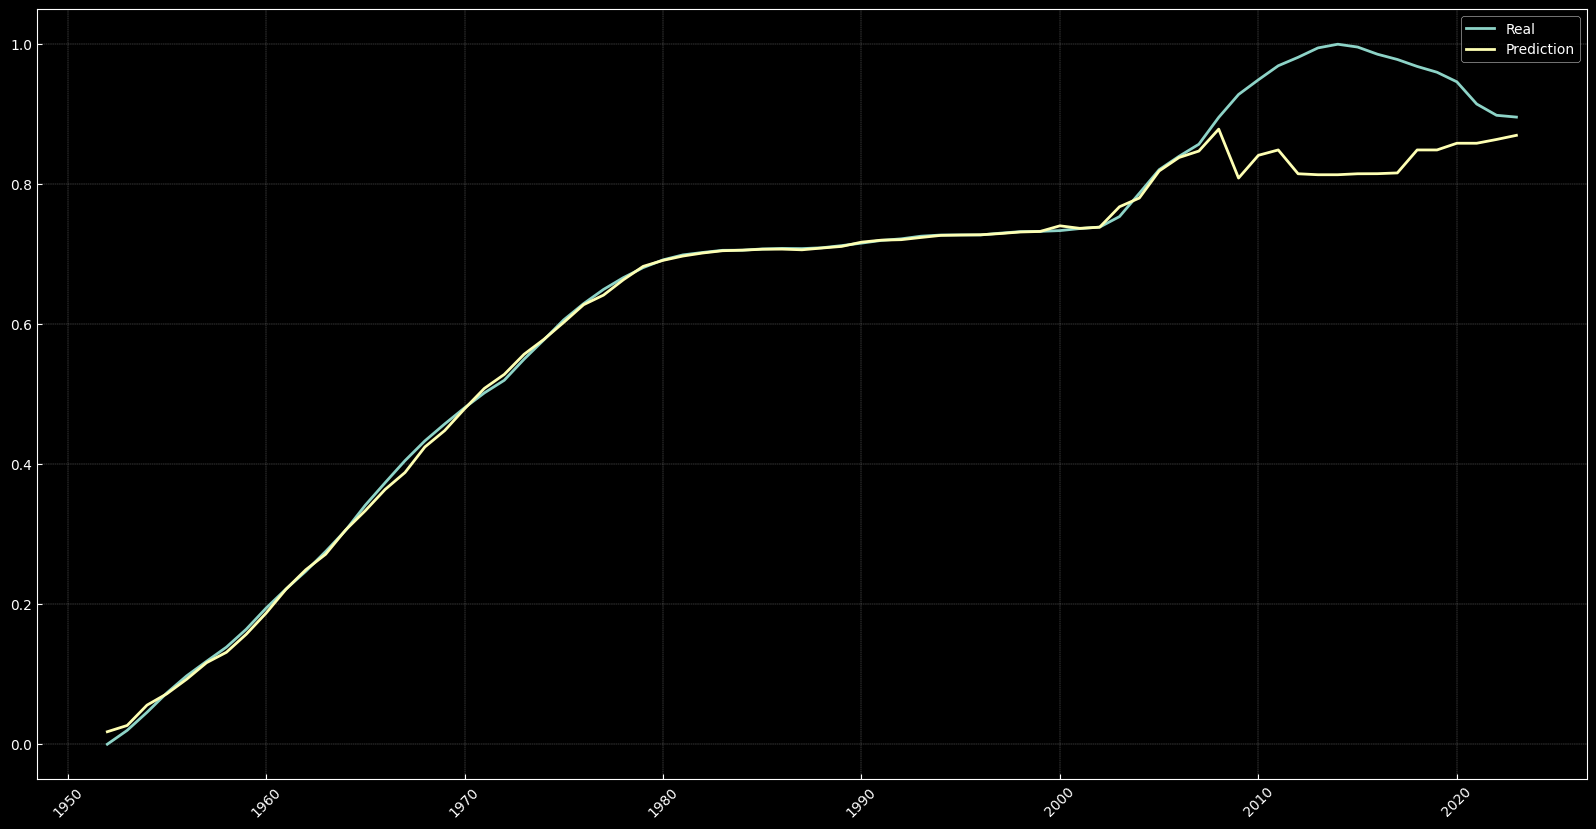

In [56]:
# [M] Random Forest Regressor

model_dir = ALL_MODEL_PATH
logs_dir = os.path.join(model_dir, 'logs/')

os.makedirs(logs_dir, exist_ok=True)

# Imposta il logging
log_file = os.path.join(logs_dir,  f'log_{datetime.now().strftime("%Y%m%d%H%M%S")}.txt')
logger = setup_logging(log_file)

# Aggiungi timestamp e informazioni sul dataset
logger.info(f"========== Report per modello completo - Demografico Economico Ambientale ==========")
logger.info(f"Timestamp: {datetime.now().strftime('%Y-%m-%d_%H:%M:%S')}")

ALL_PATH = CLEANED_DATA_COMBINED + "all/"
df = pd.read_parquet(ALL_PATH + 'all.parquet')

logger.info(f"Dataset Path: {ALL_PATH + 'all.parquet'}")
logger.info(f"Model: RandomForest Regressor\n")

cutoff = 0.8

cutoff_lenght = int(len(df["Anno"].unique()) * cutoff)

logger.info(f"Train Cut Off: {cutoff:.2f}")
logger.info(f"Test Cut Off: {1 - cutoff:.2f}\n")

try:
    df_train = df[:cutoff_lenght]
    df_test = df[cutoff_lenght:]

    x_train = df_train[['Anno', 'real_GDP', 'tas']]
    y_train = df_train['Popolazione_Totale']

    x_test = df_test[['Anno', 'real_GDP', 'tas']]
    y_test = df_test['Popolazione_Totale']

    model = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)

    logger.info(f"Metrics:")
    logging.info(f"\tMAE: {mean_absolute_error(y_test, y_pred)}")
    logging.info(f"\tMSE: {mean_squared_error(y_test, y_pred)}")
    logging.info(f"\tRMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
    logging.info(f"\tR2: {r2_score(y_test, y_pred)}\n")

    filename = model_dir + f"model.pkl"
    joblib.dump(model, filename)

    y_pred = model.predict(df[['Anno', 'real_GDP', 'tas']])
    
    with plt.style.context('default'):
        for tree in model.estimators_[:20]:
            tree_viz = tree_dir + f'tree_{model.estimators_.index(tree)}.png'
            plt.figure(figsize=(20, 10))
            plot_tree(tree, feature_names=['Anno', 'real_GDP', "tas"], filled=True)
            plt.title("Albero Decisionale del Random Forest")
            plt.savefig(tree_viz, format='png', dpi=300)
            plt.close()
    
    with plt.style.context('dark_background'):
        plt.figure(figsize=(20, 10))
        plt.plot(df['Anno'], df["Popolazione_Totale"], label='Real')
        plt.plot(df['Anno'], y_pred, label='Prediction')
        plt.xticks(rotation=45)

        plt.legend()
        plt.grid(True, color='gray', linestyle='--', linewidth=0.3)

        plt.savefig(os.path.join(model_dir, "real_vs_prediction.png"))  

    tree_dir = model_dir + 'trees/'
    os.makedirs(tree_dir, exist_ok=True)  
    

except Exception as e:
    logger.error(f"Errore durante l'addestramento del modello per il dataset : {str(e)}")

finally:
    logger.info(f"=====================================\n")
    close_logger(logger)
